# P1 - Modelos Avanzados de Análisis de Datos


Estudiantes:

    Integrante 1: David Guillermo Guerrero Calderón Código: 201113487
    
    Integrante 2: Jhon Jairo Melo Jiménez Código: 201818750
    
    Integrante 3: Julián David Moreno Marin Código: 200822194
    
    Integrante 4: Oscar Iván Castro Buitrago Código: 201315998
    
    Integrante 5: Wilson Camilo Sánchez Forero Código: 201820379

# 1. Choosing your time series (Friday July 11th).

For the project, each group must select a dataset of their choice where the analysis can be performed using a time series model. There are many sources of time series data on the Internet. Government agencies are some of the best sources. But be resourceful. It is better to find a data set is from a process that interests you. Use a recent time-series, also try to avoid a tipical stock-price / exchange rates series. The selected time series must be sent no later than Sunday, July 11, 11:59 pm, through Sicua +, for approval.
    

# 2. Analysis of the context of the problem and relevance of the analysis

This should answer the question of why it is interesting or important to study the selected data.



En uno de los bancos más grandes del país, se genera una cantidad muy grande de información a partir de data no estructurada que se genera en los contactos que se hacen a través de chat por parte de los clientes. Se creó un modelo de clasificación de data no estructurada, que permite leer todos estos chats, y clasificar cada chat en 28 productos financieros y 32 motivos de interacción de clientes.

Para este ejercicio, estamos tomando la información clasificada como posible fraude, que comprende datos entre el 3 de enero de 2020 y el 28 de septiembre de 2020, y el objetivo de ejecutar el modelo ARIMA y Prophet sobre esta serie de tiempo de 270 datos, es poder predecir los contactos que va a recibir el canal de chat de este banco, por motivo de posible fraude, y en consecuencia entender con esta muestra de información el comportamiento del nivel de fraude contra el banco a través del tiempo.

# 3. Understanding the data

Understand and analyze the main components of the time series, for example: seasonality, cyclicity, autocorrelation, behavior of the residuals, among others. Make use of graphs that allow you to understand each of the components clearly.

In [1]:
# Importamos las librerias necesarias para el procesamiento de la información

import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


Importing plotly failed. Interactive plots will not work.


In [2]:
# Leemos la serie de tiempo
df_chats = pd.read_excel('base_modelos_avanzados_v2.xlsx')
df_chats

,ds,y
0,2020-01-03,9296
1,2020-01-04,5817
2,2020-01-05,3489
3,2020-01-06,4127
4,2020-01-07,10148
...,...,...
265,2020-09-24,9250
266,2020-09-25,8817
267,2020-09-26,5521
268,2020-09-27,3259


In [3]:
df_chats.info

<bound method DataFrame.info of             ds      y
0   2020-01-03   9296
1   2020-01-04   5817
2   2020-01-05   3489
3   2020-01-06   4127
4   2020-01-07  10148
..         ...    ...
265 2020-09-24   9250
266 2020-09-25   8817
267 2020-09-26   5521
268 2020-09-27   3259
269 2020-09-28   9253

[270 rows x 2 columns]>

In [4]:
# Asignamos la fecha como índice del dataframe
df_chats.set_index('ds', inplace=True)
df_chats.head()

,y
ds,
2020-01-03,9296
2020-01-04,5817
2020-01-05,3489
2020-01-06,4127
2020-01-07,10148


Text(0, 0.5, 'Cantidad')

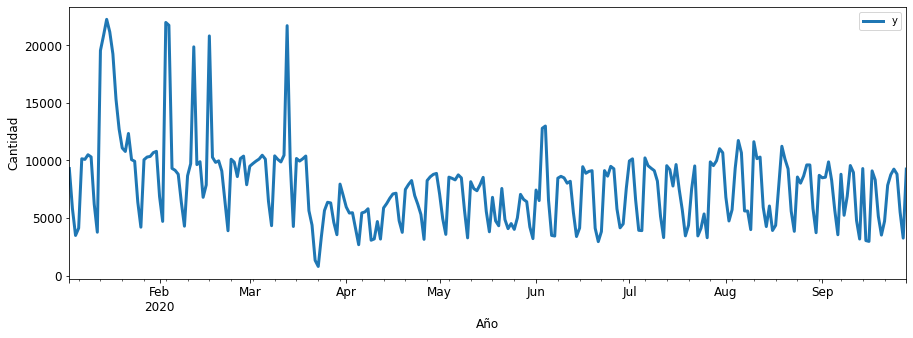

In [5]:
# Graficamos el comportamiento de la serie de tiempo
df_chats.plot(figsize=(15,5), linewidth=3, fontsize=12)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

Podemos observar en la gráfica anterior, el comportamiento de la serie de tiempo entre el 3 de enero y el 28 de septiembre de 2020, una serie de comportamiento constante, con unos valores atípicos al inicio de año, seguramente por flujos atípicos generados por el inicio de la pandemia generada por el COVID 19.

Text(0, 0.5, 'Cantidad')

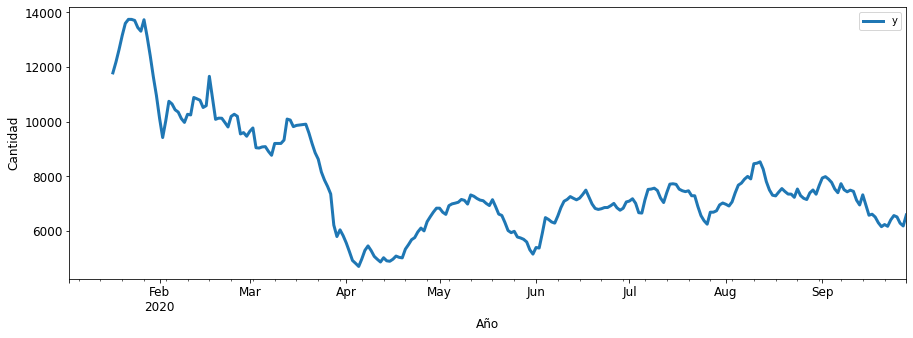

In [6]:
df_chats.rolling(15).mean().plot(figsize=(15,5), linewidth=3, fontsize=12)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

En la gráfica anterior, observamos la tendencia de la serie de tiempo, se aprecia unos valores áltos de contacto por posible fraude en los primeros meses del año, seguido de un bajón fuerte en abril (que coincide con las restricciones fuertes por parte del gobierno, para contener la transmisión de Covid 19), y a continuación una estabilización de la tendencia a partir de junio 2020.

Text(0, 0.5, 'Cantidad')

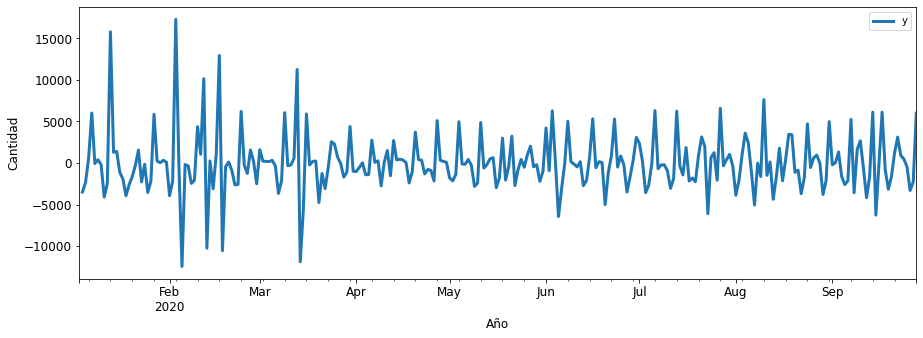

In [7]:
df_chats.diff().plot(figsize=(15,5), linewidth=3, fontsize=12)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

Haciendo un análisis de estacionalidad, apreciamos picos que se presentan especialmente en los primeros días de la semana, en general una demanda alta entre semana, con unos bajos los fines de semana, especialmente los domingos.

In [8]:
result = adfuller(df_chats)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.899357
p-value: 0.045423
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


Ejecutando el test de Dickey-Fuller para ver si la serie que tenemos es estacionaria, y con un p-value=0.045423 rechazamos la hipótesis nula, es decir, aceptamos la hipótesis alternativa de la prueba, que nos indica que la serie si es estacionaria.

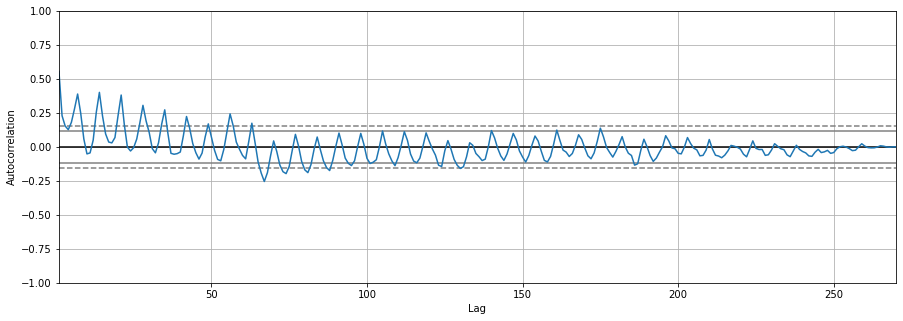

In [9]:
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(df_chats);

En la gráfica de autocorrelación podemos observar picos constantes de autocorrelación para esta serie de tiempo, que se presentan desde lag=0 hasta aproximadamente lag=60.

# Application of the models in predictions



Correct use of the models seen in class to make predictions related to the problem of interest.



Para esta serie de tiempo, vamos a aplicar modelos ARIMA y el modelo aplicado a partir de la librería prophet de Facebook.

Iniciamos aplicando el análisis para ejecutar el modelo ARIMA.

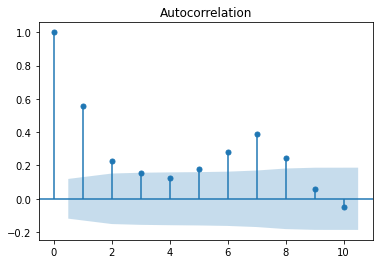

In [10]:
plot_acf(df_chats, lags=10);

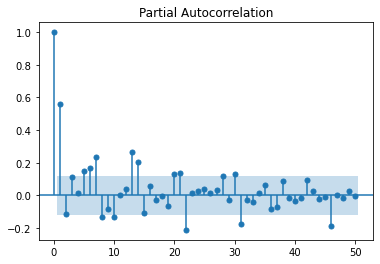

In [11]:
plot_pacf(df_chats, lags=50);


A partir de la gráfica de autocorrelación, y de autocorrelación parcial que acabamos de hallar, podemos observar que para la serie de tiempo que estamos usando en este proyecto, tenemos un modelo de tipo AR.

Continuamos con la generación del modelo ARIMA aplicado a esta serie de tiempo

Se realiza el entrenamiento del modelo, y realizamos la gráfica de los residuos en el tiempo, y la distribución, que se observa un aparente comportamiento gaussiano con media en cero.

In [12]:
model = ARIMA(df_chats, order=(7,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  270
Model:                     ARMA(7, 2)   Log Likelihood               -2529.382
Method:                       css-mle   S.D. of innovations           2827.010
Date:                Sun, 18 Jul 2021   AIC                           5080.764
Time:                        23:54:01   BIC                           5120.346
Sample:                    01-03-2020   HQIC                          5096.658
                         - 09-28-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7750.3663    637.721     12.153      0.000    6500.457    9000.276
ar.L1.y        0.3498      0.285      1.227      0.220      -0.209       0.909
ar.L2.y       -0.2217      0.333     -0.667      0.5

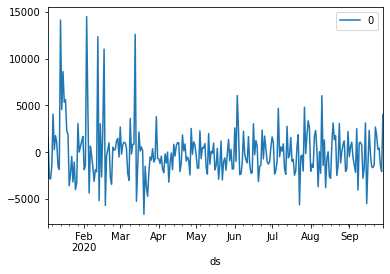

In [13]:
# gráficamos los errores residuales
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

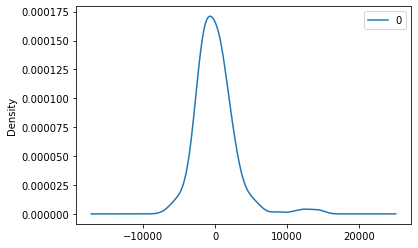

                  0
count    270.000000
mean       2.591252
std     2835.666422
min    -6652.669296
25%    -1677.297373
50%     -336.442083
75%     1064.954262
max    14493.968643


In [14]:
# gráficamos la distribución de los errores residuales.
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [15]:
X = df_chats.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

model = ARIMA(history, order=(7,0,2))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=len(test))[0]
yhat = output
predictions = yhat
real_values = future

print(pd.DataFrame({'predict':predictions, 'real':real_values}))

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


         predict     real
0    6358.924744   [4493]
1    8536.986155   [7575]
2    9576.552636   [9959]
3    9384.912420  [10143]
4    7897.240549   [6581]
..           ...      ...
87  10001.940542   [9250]
88   8538.660290   [8817]
89   6685.970814   [5521]
90   5833.286799   [3259]
91   6619.760504   [9253]

[92 rows x 2 columns]


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 4523943.170


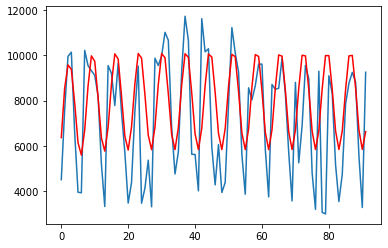

In [17]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


Para este modelo, usamos los parametros p=7, d=0, q=2, que fueron encontrados a partir de un modelo iterativo de parámetros, y fueron los valor óptimos arrojados.

Comparando los valores predichos contra los reales, viendo el error, y graficando la predicción contra los datos reales, podemos apreciar un buen ajuste en la predicción.

In [18]:
#Este fue el codigo usado para calcular los parámetros óptimos, se deja comentada porque se demora demasiado corriendo, sin embargo, los valores de parámetros óptimos que da son p=7, d=0, q=2.

""""
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = (mean_squared_error(test, predictions))
	return mse
 
# evaluate combinations of p, d and q values for an ARIMA model

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
#series = read_csv('shampoo.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(df_chats.values, p_values, d_values, q_values)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-18-9fc70d6db90d>, line 55)

Trabajamos a continuación el modelo de series de tiempo a partir de la librería prophet de Facebook.
En este caso, realizamos una predicción para 3 meses.

In [19]:
df_chats_prophet = pd.read_excel('base_modelos_avanzados_v2.xlsx')
m = Prophet()
m.fit(df_chats_prophet)
future = m.make_future_dataframe(periods=30*3*1, freq='D')
future.tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
355,2020-12-23
356,2020-12-24
357,2020-12-25
358,2020-12-26
359,2020-12-27


In [20]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
355,2020-12-23,8845.244112,5298.839400,12371.553714
356,2020-12-24,8671.795821,5014.008145,12160.063649
357,2020-12-25,7955.851422,4395.762277,11557.391042
358,2020-12-26,5271.377247,1777.125402,8738.439831
359,2020-12-27,3591.560352,-277.419223,7037.950556


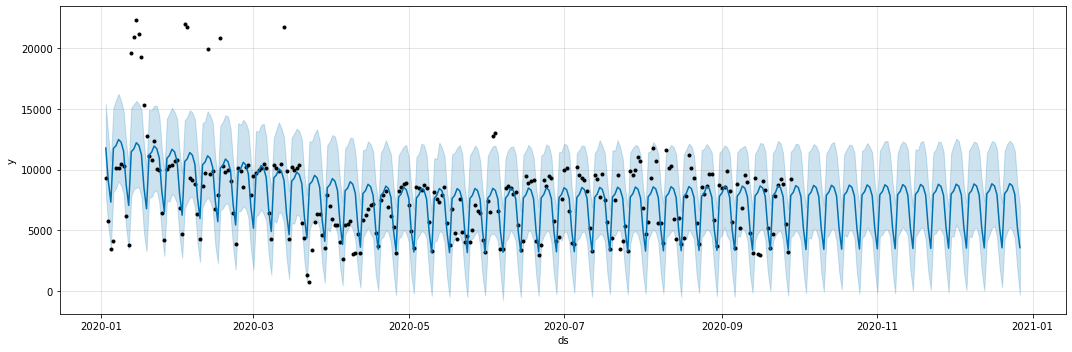

In [21]:
fig1 = m.plot(forecast,figsize=(15,5),)

Podemos ver en la gráfica anterior, como tenemos unos datos atípicos al inicio del año 2020, con un comportamiento que se estabiliza en el tiempo, y genera una predicción para los siguientes 90 días al 28 de septiembre, aparentemente estable en relación a la serie de tiempo que se encuentra entre abril y septiembre.

Esta predicción, al igual que la serie, presenta picos entre semana, y bajos en fin de semana, con respecto a los contactos relacionados pos posible fraude en el chat del banco.

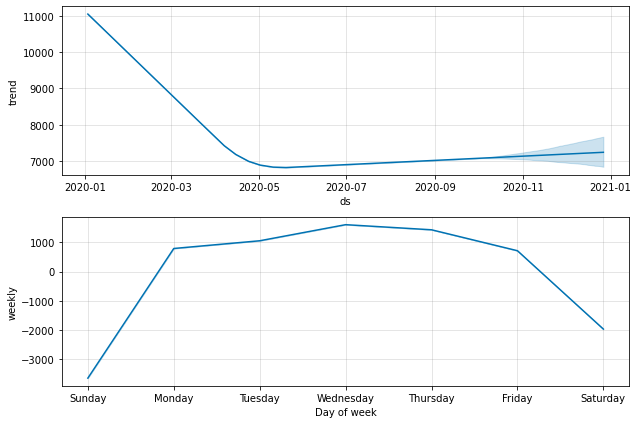

In [22]:
m.plot_components(forecast);

Graficando la tendencia, observamos una fuerte alza al inicio del año, comportamiento atípico seguramente provocado por la pandemis. Posterior, una tendencia estable con un alza leve, que se mantiene en la predicción.

In [23]:
from prophet.diagnostics import cross_validation

data_cv = cross_validation(m, initial='90 days', period='180 days', horizon='90 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2020-06-30 00:00:00 and 2020-06-30 00:00:00


In [24]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

performance_metrics(data_cv)


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,7.010896e+06,2647.809738,2378.254170,0.292081,0.291064,0.357361,0.888889
1,10 days,6.561562e+06,2561.554607,2288.142215,0.288009,0.282486,0.351900,0.888889
2,11 days,5.682095e+06,2383.714625,2125.594762,0.292806,0.282486,0.359039,0.888889
3,12 days,6.008509e+06,2451.226028,2285.783319,0.346297,0.309082,0.433335,0.888889
4,13 days,7.368752e+06,2714.544456,2615.679075,0.371269,0.371403,0.466428,0.888889
...,...,...,...,...,...,...,...,...
77,86 days,1.190916e+07,3450.964373,3241.784026,0.532283,0.462071,0.730887,0.777778
78,87 days,1.359476e+07,3687.107139,3490.215247,0.504144,0.462071,0.745791,0.666667
79,88 days,1.353550e+07,3679.062197,3483.112239,0.536118,0.488667,0.812304,0.666667
80,89 days,1.326337e+07,3641.890887,3446.078574,0.604357,0.511561,0.967760,0.666667


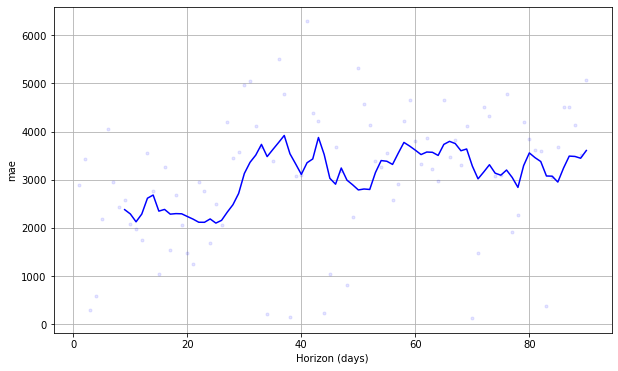

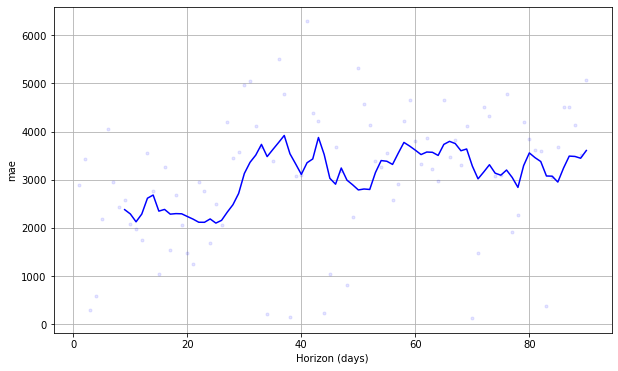

In [25]:
plot_cross_validation_metric(data_cv, metric='mae')

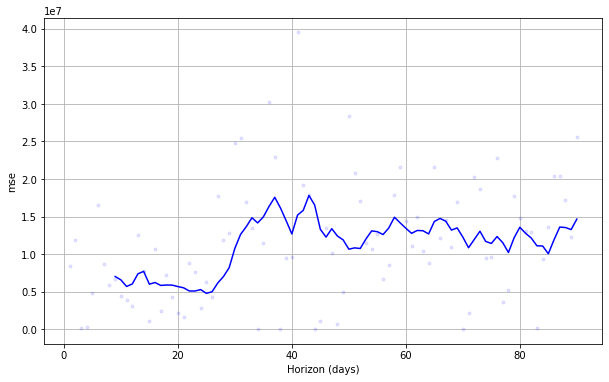

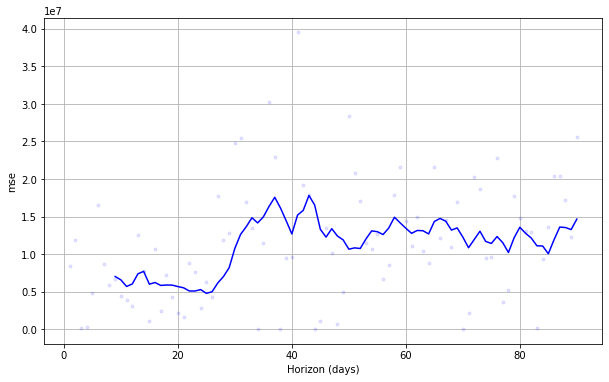

In [26]:
plot_cross_validation_metric(data_cv, metric='mse')

Finalmente, observamos diferentes medidas de error para este modelo, y sus respectivas gráficas, en diferentes horizontes de tiempo.

# Conclusions

The conclusions must be relevant to the problem of interest. Conclusions on the procedures performed are also expected.

1. La visualización del comportamiento de los contactos por fraude para este banco da una visual muy importante respecto a la demanda y a los ataques con intención de fraude, con una marcada tendencia al alza entre semana, y pico de reportes los lunes.

2. Las predicciónes realizadas por los modelos ARIMA y Prophet presentaron un buen ajuste a los datos reales, y presentan una predicción acorde al comportamiento de los datos. En los resultados de Prophet podemos ver una tendencia leve al alza en los últimos meses, que se mantiene en la predicción, lo  cual es un insight clave, y se deben tomar medidas internas para hacer lo posible para que el fraude y sus contactos a través del chat tengan una tendencia a la baja a través del tiempo.

3. ARIMA muestra un ajuste gráfico de la predicción sobre los datos bastante sobresaliente, los parámetros muestran un ajuste bueno, y generan un error menor a Prophet. Sin embargo, la información gráfica que provee Prophet y la tendencia que muestra en la predicción, permite que los modelos se complememten muy bien en los resultados obtenidoa para el problema de los contactos por chat por posible fraude para etse banco.